In [126]:
pip install -r "../../requirement.txt"

In [124]:
# make ML tools visible to system
import sys
import os
dirname = os.path.abspath('')
pardir = os.path.abspath(os.path.join(dirname, os.pardir))    
sys.path.append(os.path.join(dirname, 'tools/'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import math
import joblib

# f3dasm and necessary packages
from f3dasm import ExperimentData
import xarray as xr
import dask as dsk

# custom classes and functions
from l2o_modified import StrategyManager, open_all_datasets_post
from DataLoading import extract_features, extract_labels, train_test_split
from ModelEvaluation import compare_perf_profiles, gs_results, plot_perf_profiles
from CustomStrategies import SingleLabelStrategy

# sklearn imports
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.base import clone

In [24]:
# project directory, root directory is Scripts
PROJECT_DIR = 'Datasets/big_dataset/'

# notebook constants
TEST_SIZE = 0.2
STRATIFIED = True
N_JOBS = 4
RANDOM_STATE = 42

In [25]:
big_dataset = ExperimentData.from_file(os.path.join(pardir, PROJECT_DIR))

dsds = open_all_datasets_post(big_dataset)

CPU times: total: 2.09 s
Wall time: 21.1 s


In [26]:
# remove samples with nan values
dsds = dsds.dropna(dim='itemID', how='any')

# split data
dsds_train, dsds_test = train_test_split(
    dsds, test_size=TEST_SIZE, stratified=STRATIFIED, random_state=RANDOM_STATE
)
# put data into np arrays for training
X_train, X_test = extract_features(dsds_train), extract_features(dsds_test)
y_train, y_test = extract_labels(dsds_train), extract_labels(dsds_test)

CPU times: total: 4.11 s
Wall time: 1min 29s


In [120]:
# define model pipeline
untuned_model = Pipeline((
        [
            'poly', PolynomialFeatures(
            degree=3, 
            include_bias=False
            )
        ], 
        [
            'selector', 
            SelectKBest(
                k = 100
            )
        ], 
        [
            'estimator',
            RandomForestClassifier(
                random_state=RANDOM_STATE,
                n_jobs= N_JOBS
            )
        ]
    ))

untuned_model.fit(X_train, y_train)
joblib.dump(untuned_model, os.path.join(dirname,'models/best_model_untuned'))

['c:\\Users\\danie\\Documents\\Local_Gits\\CapstoneAI_TU_2023-2024\\Scripts\\ML\\models/best_model_untuned']

In [129]:
# untuned model performance
strategy_manager = StrategyManager(dsds_test, [SingleLabelStrategy(untuned_model, FunctionTransformer())])
pps = strategy_manager.compute_performance_profiles()

In [130]:
compare_perf_profiles(pps)

,strategy,f_one,area,f_one_score,area_score,score
6,best_perf_profile,0.215861,3.720587,1.000000,1.000000,1.000000
5,Pipeline,0.211540,3.700938,0.979983,0.994719,0.987323
2,Adam,0.063460,3.390786,0.293987,0.911358,0.517617
3,LBFGSB,0.089318,2.099667,0.413774,0.564338,0.483227
1,PSO,0.053292,3.106431,0.246882,0.834930,0.454015
0,CMAES,0.034362,3.179832,0.159187,0.854659,0.368850
4,RandomSearch,0.008471,2.252219,0.039241,0.605340,0.154123
7,worst_perf_profile,0.001612,1.647573,0.007467,0.442826,0.057502


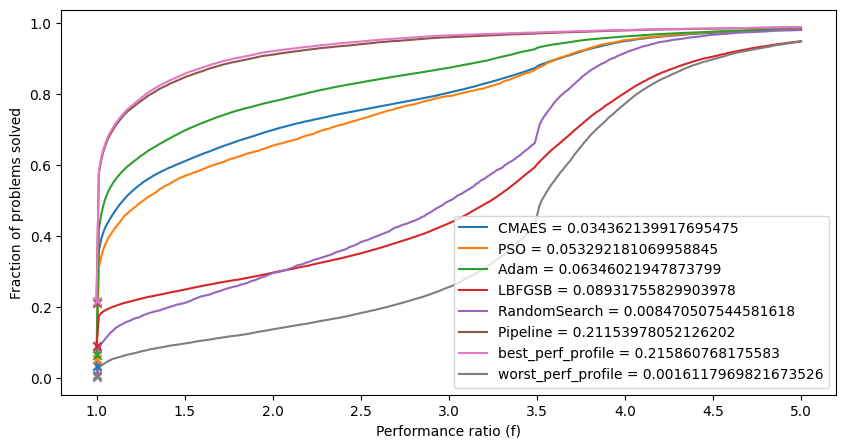

In [8]:
plot_perf_profiles(pps)
#plt.savefig('best_model_untuned')

In [19]:
# how long to run in seconds
timeout = 0.25*60**2

def objective(trial):
    # hyperparameters
    degree = 3
    interaction_only = False
    k_max = (np.arange(12,12-degree,-1)*np.arange(1,degree+1)).sum() if interaction_only else math.comb(12+degree,degree)-1
    k = trial.suggest_int('selector__k',4,k_max)
    
    # call model and set parameters
    clf = clone(untuned_model).set_params(**{
        'selector__k' : k,
    })

    # return cross validation accuracy
    return cross_val_score(clf,X_train,y_train,n_jobs=N_JOBS).mean()

study = optuna.create_study(direction='maximize', study_name='15_min_tune_k')
study.optimize(objective, n_trials=None, timeout=timeout, gc_after_trial=True, n_jobs=N_JOBS)

[I 2024-01-25 13:41:21,492] A new study created in memory with name: 15_min_tune_k
[I 2024-01-25 13:41:35,677] Trial 0 finished with value: 0.8305895513782632 and parameters: {'selector__k': 321}. Best is trial 0 with value: 0.8305895513782632.
[I 2024-01-25 13:41:48,785] Trial 3 finished with value: 0.8320044801990546 and parameters: {'selector__k': 305}. Best is trial 3 with value: 0.8320044801990546.
[I 2024-01-25 13:41:57,026] Trial 2 finished with value: 0.8315328188822564 and parameters: {'selector__k': 243}. Best is trial 3 with value: 0.8320044801990546.
[I 2024-01-25 13:41:59,407] Trial 1 finished with value: 0.8303324912286506 and parameters: {'selector__k': 416}. Best is trial 3 with value: 0.8320044801990546.
[I 2024-01-25 13:42:02,617] Trial 4 finished with value: 0.8284466912820344 and parameters: {'selector__k': 96}. Best is trial 3 with value: 0.8320044801990546.
[I 2024-01-25 13:42:10,066] Trial 5 finished with value: 0.8295181443008165 and parameters: {'selector__k': 

CPU times: total: 46.5 s
Wall time: 15min 35s


In [21]:
study.trials_dataframe().to_csv(os.path.join(dirname,'studies/',study.study_name))
study.trials_dataframe().sort_values('value', ascending=False).head(50)

,number,value,datetime_start,datetime_complete,duration,params_selector__k,state
100,100,0.833162,2024-01-25 13:54:47.214245,2024-01-25 13:55:23.432698,0 days 00:00:36.218453,316,COMPLETE
98,98,0.833162,2024-01-25 13:54:32.181565,2024-01-25 13:55:05.218851,0 days 00:00:33.037286,316,COMPLETE
18,18,0.832562,2024-01-25 13:43:21.002041,2024-01-25 13:43:57.511495,0 days 00:00:36.509454,317,COMPLETE
54,54,0.832519,2024-01-25 13:48:18.588103,2024-01-25 13:48:51.450172,0 days 00:00:32.862069,314,COMPLETE
62,62,0.832476,2024-01-25 13:49:31.279661,2024-01-25 13:50:09.431594,0 days 00:00:38.151933,309,COMPLETE
94,94,0.832476,2024-01-25 13:53:58.658361,2024-01-25 13:54:31.629650,0 days 00:00:32.971289,263,COMPLETE
110,110,0.832390,2024-01-25 13:56:20.779199,2024-01-25 13:56:56.633929,0 days 00:00:35.854730,358,COMPLETE
99,99,0.832390,2024-01-25 13:54:39.650655,2024-01-25 13:55:15.382494,0 days 00:00:35.731839,311,COMPLETE
101,101,0.832390,2024-01-25 13:54:57.261286,2024-01-25 13:55:34.112706,0 days 00:00:36.851420,311,COMPLETE
56,56,0.832390,2024-01-25 13:48:36.899235,2024-01-25 13:49:09.258640,0 days 00:00:32.359405,311,COMPLETE


In [112]:
study_df = pd.read_csv(os.path.join(dirname,'studies/','2.5_hour_selectkbest'))
study_df.head(1)

,Unnamed: 0,number,value,datetime_start,datetime_complete,duration,params_estimator__bootstrap,params_estimator__class_weight,params_estimator__criterion,params_estimator__max_depth,...,params_estimator__max_leaf_nodes,params_estimator__max_samples,params_estimator__min_impurity_decrease,params_estimator__min_weight_fraction_leaf,params_estimator__n_estimators,params_estimator__oob_score,params_poly__degree,params_poly__interaction_only,params_selector__k,state
0,0,0,0.710391,2024-01-25 02:15:45.965747,2024-01-25 02:15:54.449639,0 days 00:00:08.483892,False,balanced,log_loss,8,...,1215,NaN,1.530826e-07,0,150,NaN,3,True,16,COMPLETE


In [113]:
best_params = {
'estimator__bootstrap': False,
 'estimator__class_weight': 'balanced',
 'estimator__criterion': 'log_loss',
 'estimator__max_depth': 8,
 'estimator__max_features': 'log2',
 'estimator__max_leaf_nodes': 1215,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 1.5308259594951968e-07,
 'estimator__min_weight_fraction_leaf': 0,
 'estimator__n_estimators': 150,
 'estimator__oob_score': False,
 'poly__degree': 3,
 'poly__interaction_only': True,
 'selector__k': 16
}

In [114]:
tuned_model = clone(untuned_model).set_params(**best_params).fit(X_train,y_train)
joblib.dump(tuned_model, os.path.join(dirname,'models/best_model_tuned'))

['c:\\Users\\danie\\Documents\\Local_Gits\\CapstoneAI_TU_2023-2024\\Scripts\\ML\\models/best_model_tuned']

In [117]:
# tuned model performance
strategy_manager_tuned = StrategyManager(dsds_test, [SingleLabelStrategy(tuned_model, FunctionTransformer()),])
pps_tuned = strategy_manager_tuned.compute_performance_profiles()

In [118]:
compare_perf_profiles(pps_tuned)

,strategy,f_one,area,f_one_score,area_score,score
6,best_perf_profile,0.215861,3.720587,1.000000,1.000000,1.000000
5,Pipeline,0.185099,3.563709,0.857495,0.957835,0.906277
2,Adam,0.063460,3.390786,0.293987,0.911358,0.517617
3,LBFGSB,0.089318,2.099667,0.413774,0.564338,0.483227
1,PSO,0.053292,3.106431,0.246882,0.834930,0.454015
0,CMAES,0.034362,3.179832,0.159187,0.854659,0.368850
4,RandomSearch,0.008471,2.252219,0.039241,0.605340,0.154123
7,worst_perf_profile,0.001612,1.647573,0.007467,0.442826,0.057502


(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='Performance ratio (f)', ylabel='Fraction of problems solved'>)

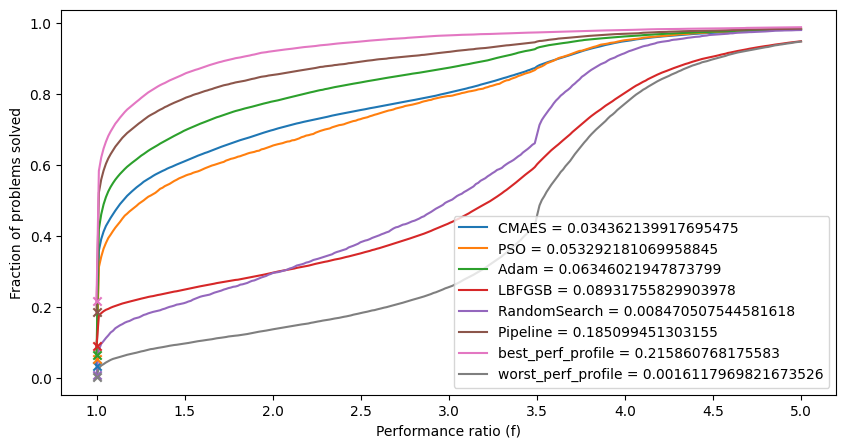

In [119]:
plot_perf_profiles(pps_tuned)
#plt.savefig('best_model_tuned')

We were unable to get a better performance that the untuned model through tuning, so we will using the untuned model for the final product.